In [1]:
import sys
import os

# the path that contains SFCN codes
SFCN_path = "../UKBiobank_deep_pretrain-master"
sys.path.append(SFCN_path)

In [2]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
import nibabel as nib
from nilearn import plotting
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [4]:
# block randomness
import random
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Obtain Data Info

In [5]:
data_info_df = pd.read_csv("./data_info/T1_MNI_20252_2_0/T1_MNI_20252_2_0.csv")

print(len(data_info_df))
print(f"max age: {data_info_df['f.21003.2.0'].max()}, min age: {data_info_df['f.21003.2.0'].min()},")

40681
max age: 82.0, min age: 44.0,


## HC

In [6]:
HC_info_df = data_info_df[(data_info_df["status"]=="HC") & (data_info_df["path"].notna())]
HC_info_df.set_index("f.eid", inplace=True)
HC_info_df

,f.21003.2.0,f.20126.0.0,f.2976.2.0,status,path,MNI
f.eid,,,,,,
1198929,70.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
3030287,60.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
3055051,71.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
2828573,59.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
2507464,70.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
...,...,...,...,...,...,...
4351668,58.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
4386787,53.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True
4247063,66.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True


## MDD

In [7]:
MDD_info_df = data_info_df[(data_info_df["status"]=="mdd") & (data_info_df["path"].notna())]
MDD_info_df.set_index("f.eid", inplace=True)
MDD_info_df

,f.21003.2.0,f.20126.0.0,f.2976.2.0,status,path,MNI
f.eid,,,,,,
3303915,72.0,5.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
3111573,69.0,4.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
2688028,60.0,4.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
2330198,63.0,5.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
1244402,77.0,4.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
...,...,...,...,...,...,...
5743070,77.0,3.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
4966663,70.0,3.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True
4947696,60.0,4.0,NaN,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True


## Peek at one sample

In [8]:
img_path = MDD_info_df.loc[4947696]["path"]
img = nib.load(img_path) ## nifti file
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


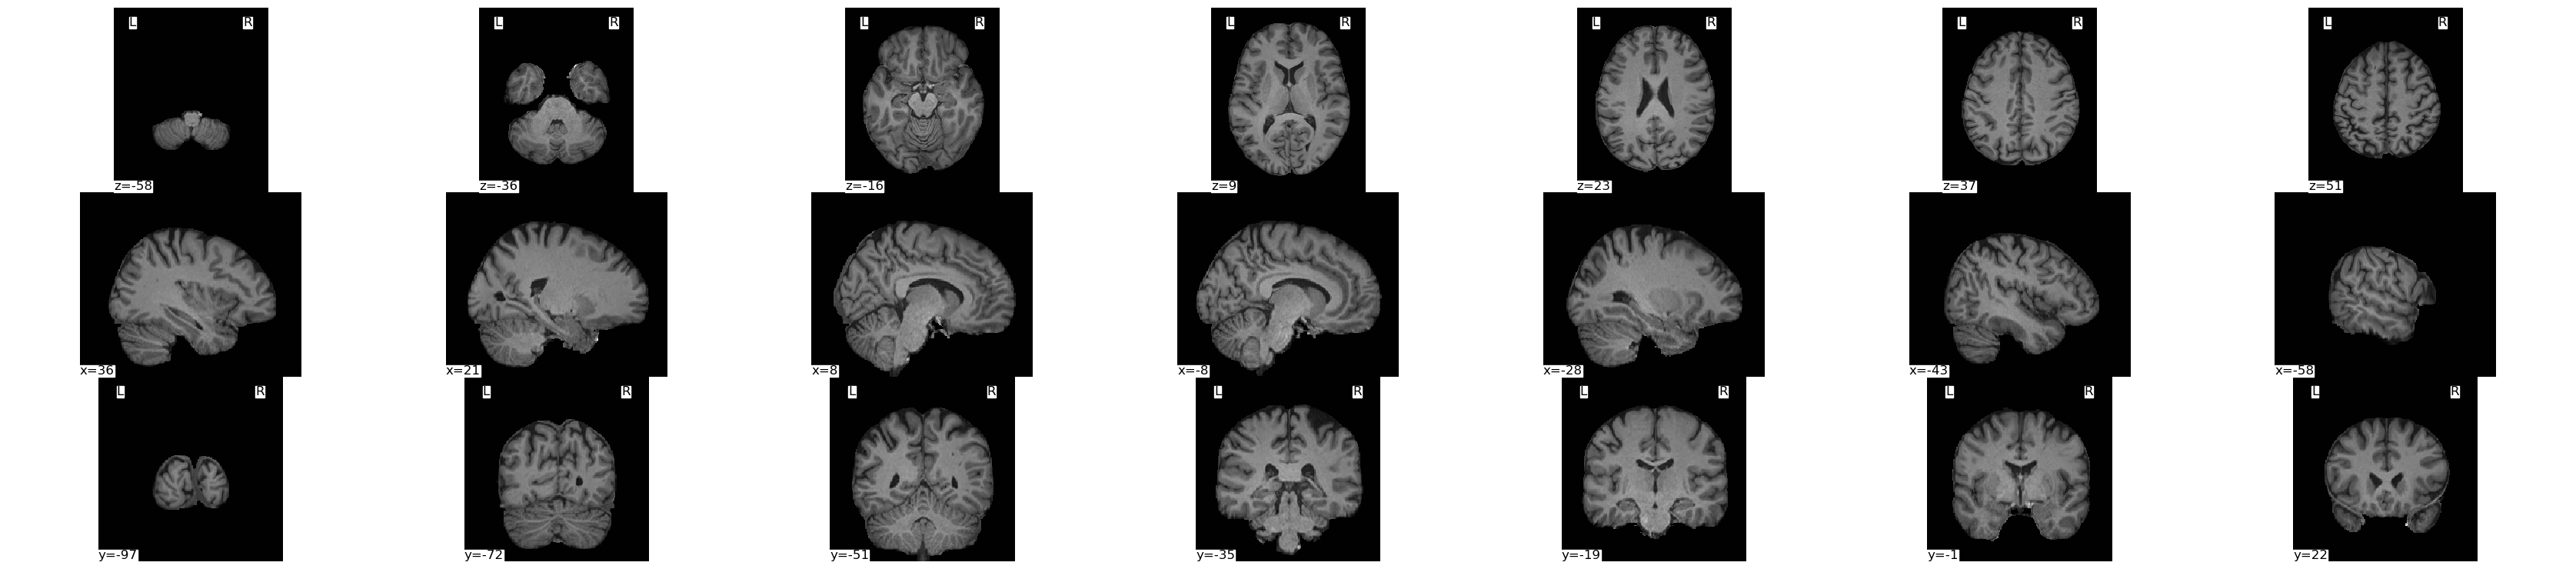

In [9]:
plotting.plot_img(img, display_mode='mosaic', cmap='gray')
plt.show()

In [10]:
img_raw_arr = img.get_fdata()
print(type(img_raw_arr))
print(img_raw_arr.shape)
print(f"max: {img_raw_arr.max()}, min: {img_raw_arr.min()}, avg: {img_raw_arr.mean()}")

<class 'numpy.ndarray'>
(182, 218, 182)
max: 2327.0, min: -34.0, avg: 228.7637776705601


In [11]:
# Preprocessing
img_arr_0 = img_raw_arr/img_raw_arr.mean()
img_arr = dpu.crop_center(img_arr_0, (160, 192, 160))
print(img_arr.shape)
print(f"max: {img_arr.max()}, min: {img_arr.min()}, avg: {img_arr.mean()}")

(160, 192, 160)
max: 10.172064929575887, min: -0.14862492806428027, avg: 1.4654115973621598


# Create batched data from batched paths

## Obtain path list

In [15]:
HC_path_list = HC_info_df["path"].tolist()
print(len(HC_path_list))
HC_path_list[:5]

6802


['/disk/scratch/s2442138/data/T1_MNI_20252_2_0/HC/1198929/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/HC/3030287/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/HC/3055051/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/HC/2828573/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/HC/2507464/T1/T1_brain_to_MNI.nii.gz']

In [16]:
MDD_path_list = MDD_info_df["path"].tolist()
print(len(MDD_path_list))
MDD_path_list[:5]

2461


['/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/3303915/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/3111573/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/2688028/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/2330198/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/1244402/T1/T1_brain_to_MNI.nii.gz']

## Help Functions

In [9]:
def obtain_arr_from_nii(path):
    """
    extract + crop
    """
    # extract nii object
    img = nib.load(path)
    # extract raw arr data
    img_raw_arr = img.get_fdata()
    # preprocess
    img_arr_0 = img_raw_arr/img_raw_arr.mean()
    img_arr = dpu.crop_center(img_arr_0, (160, 192, 160)) # crop
    return img_arr

In [10]:
def create_dataset_from_nii_path_list(path_list):
    """
    extract array of nii image from path_list, 
    crop,
    return np array of shap (n_samples, 1, 160, 192, 160)
    """
    arr_list = []

    for path in path_list:
    
        # get image array data
        img_arr = obtain_arr_from_nii(path) # (160, 192, 160)
    
        # reshape -- add batch size, channel size
        sp = (1,1) + img_arr.shape 
        img_arr_reshape = img_arr.reshape(sp) # (1, 1, 160, 192, 160)
        
        arr_list.append(img_arr_reshape)
    
    data_arr = np.vstack(arr_list)
    return data_arr

## Not Used -- Ignore this part

### HC dataset

**The order of scan is the same as the order in `HC_info_df`**

In [46]:
HC_path_list = HC_info_df["path"].tolist()
HC_count = len(HC_path_list)
HC_count

300

In [47]:
HC_data_arr = create_dataset_from_nii_path_list(HC_path_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:13<00:00,  4.10it/s]


In [49]:
print((HC_data_arr[0] == HC_data_arr[7]).all())

False


#### save & load

300 is too much to store, no space disk available

100 --> 3.7G

In [50]:
HC_num = 100 # should <= HC_count
HC_dataset_path = f"./data/T1_MNI_20252_2_0/HC_data_{HC_num}.npy"

In [51]:
with open(HC_dataset_path, 'wb') as f:
    np.save(f, HC_data_arr[:HC_num])

In [52]:
with open(HC_dataset_path, 'rb') as f:
    HC_data_arr = np.load(f)

In [53]:
print(HC_data_arr.shape)
print(HC_data_arr.min())
print(HC_data_arr.max())
print(HC_data_arr.mean())

(100, 1, 160, 192, 160)
-0.667453366575311
18.35960267364449
1.465289658461411


### MDD dataset

**The order of scans is the same with the order recorded in `MDD_info_df`**

In [54]:
MDD_path_list = MDD_info_df["path"].tolist()
MDD_count = len(MDD_path_list)
MDD_count

100

In [55]:
MDD_data_arr = create_dataset_from_nii_path_list(MDD_path_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


In [56]:
print((MDD_arr_list[9]==MDD_arr_list[90]).all())

False


#### save & load

In [57]:
MDD_num = 30 # should <= MDD_count
MDD_dataset_path = f"./data/T1_MNI_20252_2_0/MDD_data_{MDD_num}.npy"

In [58]:
with open(MDD_dataset_path, 'wb') as f:
    np.save(f, MDD_data_arr[:MDD_num])

In [59]:
with open(MDD_dataset_path, 'rb') as f:
    MDD_data_arr = np.load(f)

In [60]:
print(MDD_data_arr.shape)
print(MDD_data_arr.min())
print(MDD_data_arr.max())
print(MDD_data_arr.mean())

(30, 1, 160, 192, 160)
-0.38068427536307453
18.438912122192555
1.465260099194049


In [68]:
print((MDD_data_arr[0] == HC_data_arr[0]).all())

False


# Inference HC brain age

## Load the model

Model input shape: [batch_size, 1, 160, 192, 160]

In [3]:
retrain = True
state_dict_path = "./trained_SFCN/UKBB_HC/UKBB_HC_best.pth"

model = SFCN()
model = torch.nn.DataParallel(model)

if not retrain:
    fp_ = os.path.join(SFCN_path, './brain_age/run_20190719_00_epoch_best_mae.p')
    model.load_state_dict(torch.load(fp_))
else:
    state_dict = torch.load(state_dict_path) 
    model.load_state_dict(state_dict['model'])

model.cuda()

DataParallel(
  (module): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, 

## Get bin center

In [12]:
## a one-year age interval between 42 to 82 (for UK Biobank)
bin_center = np.arange(start=42.5, stop=82, step=1)
bin_center

array([42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5,
       53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5,
       64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5,
       75.5, 76.5, 77.5, 78.5, 79.5, 80.5, 81.5])

## Help Functions

In [5]:
def inference_brain_age(data_loader, bin_center):
    age_pred_list = []

    for batch_ndx, paths in enumerate(tqdm(data_loader)):
        # get stacked array from paths, convert to tensor
        samples = torch.from_numpy(create_dataset_from_nii_path_list(paths))
        n_sample = samples.shape[0]
        samples = samples.type(torch.FloatTensor).cuda() ## double to float to cuda
    
        model.eval()
        with torch.no_grad():
            # a list of only one element: a tensor of size [samples.shape[0], 40, 1, 1, 1], in GPU
            output_list = model(samples)
    
        # to CPU and reshape to [samples.shape[0], 40]
        output_tensor =  output_list[0].cpu().reshape([n_sample, -1])
        output_arr = output_tensor.numpy()
    
        # exp: map from log domin to prob
        prob_dist = np.exp(output_arr) 
        prediction = prob_dist @ bin_center
    
        age_pred_list.extend(prediction)
        
    return age_pred_list

In [6]:
def bias_correction(y: np.ndarray, y_pred: np.ndarray):
    """
    :param y: chronological age (ground truth)
    :param y_pred: brain age before bias correction (predictions)
    :return: bias-corrected brain age
    """
    # Smith2019 bias correction
    linear_fit = LinearRegression(fit_intercept=True).fit(
        X=y, y=y_pred
    )
    intercept, slope = linear_fit.intercept_, linear_fit.coef_[0]
    y_pred_unbiased = (y_pred - intercept) / (slope + np.finfo(np.float32).eps) # avoid division by 0
    return y_pred_unbiased, intercept, slope

In [7]:
def plot_bias_correction_result(x, y, slope, intercept):
    """
    x: predicted age, np array
    y: chronological age, np array
    """
    slope = slope + np.finfo(np.float32).eps
    
    plt.plot(x, y, 'o', label='data')
    yy = np.linspace(40, 85, 200) # pred_unbiased
    xx = slope * yy + intercept # pred
    plt.plot(xx, yy, label=f"least squares fit, x = {slope} y + {intercept}")
    plt.xlabel('x: prediected age')
    plt.ylabel('y: chronological age')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

## Try one example

In [11]:
paths = ['/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/3303915/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/3111573/T1/T1_brain_to_MNI.nii.gz',
 '/disk/scratch/s2442138/data/T1_MNI_20252_2_0/mdd/2688028/T1/T1_brain_to_MNI.nii.gz']

batch_size = 1
loader = DataLoader(paths, batch_size=batch_size, pin_memory=True)
inference_brain_age(loader, bin_center)

# original model: [67.65552629636477, 60.40139634592924, 56.25511708837075]
# retrianed model: 

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


[69.68790193200402, 70.27549199965142, 59.38645160665328]

## predict HC brain age

In [52]:
batch_size = 50
HC_loader = DataLoader(HC_path_list, batch_size=batch_size, pin_memory=True)  ## NO shuffle

In [53]:
HC_age_pred_list = inference_brain_age(HC_loader, bin_center)

print(len(HC_age_pred_list))

100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [17:34<00:00,  7.70s/it]

6802


In [54]:
HC_num = len(HC_age_pred_list)
HC_pred_df = HC_info_df.head(HC_num)[["f.21003.2.0"]]
HC_pred_df["age_pred"] = HC_age_pred_list
HC_pred_df

,f.21003.2.0,age_pred
f.eid,,
1198929,70.0,58.789781
3030287,60.0,56.418017
3055051,71.0,63.230960
2828573,59.0,55.169477
2507464,70.0,65.875464
...,...,...
4351668,58.0,55.288613
4386787,53.0,53.630884
4247063,66.0,60.693258


### Bias correction

In [55]:
# intercept and slope is for later use of MDD samples
HC_age_unbiased, intercept, slope = bias_correction(HC_pred_df["f.21003.2.0"].to_numpy().reshape(-1, 1), HC_pred_df["age_pred"].to_numpy().reshape(-1, 1))
HC_pred_df["age_unbiased"] = HC_age_unbiased
HC_pred_df

,f.21003.2.0,age_pred,age_unbiased
f.eid,,,
1198929,70.0,58.789781,62.630661
3030287,60.0,56.418017,59.309585
3055051,71.0,63.230960,68.849447
2828573,59.0,55.169477,57.561309
2507464,70.0,65.875464,72.552430
...,...,...,...
4351668,58.0,55.288613,57.728130
4386787,53.0,53.630884,55.406887
4247063,66.0,60.693258,65.296015


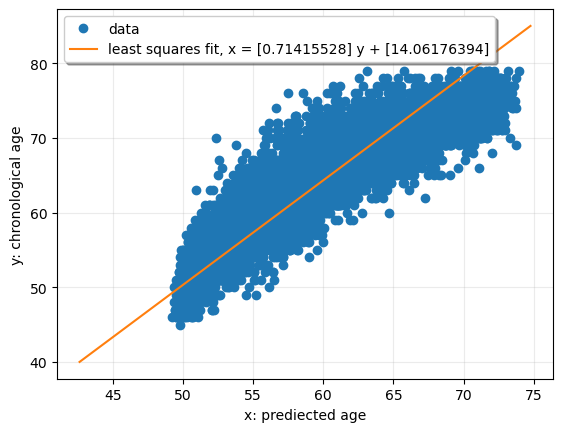

In [56]:
plot_bias_correction_result(HC_pred_df["age_pred"].to_numpy(), HC_pred_df["f.21003.2.0"].to_numpy(), slope, intercept)

### Compute error

In [13]:
HC_pred_df["error"] = HC_pred_df["age_unbiased"] - HC_pred_df["f.21003.2.0"]
HC_pred_df

,f.21003.2.0,age_pred,age_unbiased,error
f.eid,,,,
1198929,70.0,58.789781,62.630661,-7.369339
3030287,60.0,56.418017,59.309585,-0.690415
3055051,71.0,63.230960,68.849447,-2.150553
2828573,59.0,55.169477,57.561309,-1.438691
2507464,70.0,65.875464,72.552430,2.552430
...,...,...,...,...
4351668,58.0,55.288613,57.728130,-0.271870
4386787,53.0,53.630884,55.406887,2.406887
4247063,66.0,60.693258,65.296015,-0.703985


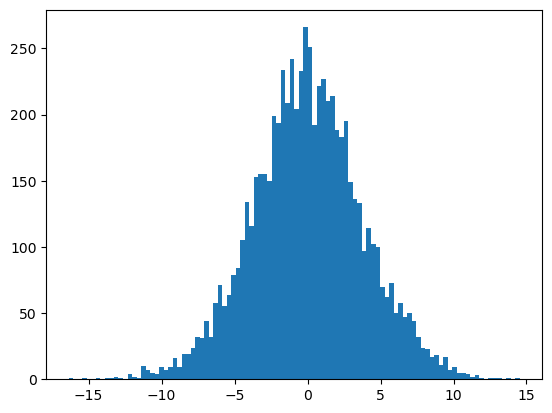

In [22]:
plt.hist(HC_pred_df["error"], 100)
plt.show()

In [24]:
HC_pred_df["error"].describe()

count    6802.000000
mean       -0.000011
std         3.788400
min       -16.351721
25%        -2.398676
50%        -0.046444
75%         2.433797
max        14.541213
Name: error, dtype: float64

In [9]:
print(mean_absolute_error(HC_pred_df["f.21003.2.0"], HC_pred_df["age_unbiased"]))
print(mean_squared_error(HC_pred_df["f.21003.2.0"], HC_pred_df["age_unbiased"]))

2.9692007952663886
14.349862724418466


### Save Results

In [15]:
HC_num = len(HC_pred_df)

In [16]:
# save prediction results
HC_pred_df.to_csv(f"./data_info/T1_MNI_20252_2_0/HC_pred_age_{HC_num}.csv")

In [13]:
HC_pred_df = pd.read_csv("./data_info/T1_MNI_20252_2_0/HC_pred_age_6802.csv")
HC_pred_df.set_index("f.eid", inplace=True)
HC_pred_df

,f.21003.2.0,age_pred,age_unbiased,error
f.eid,,,,
1198929,70.0,58.789781,62.630661,-7.369339
3030287,60.0,56.418017,59.309585,-0.690415
3055051,71.0,63.230960,68.849447,-2.150553
2828573,59.0,55.169477,57.561309,-1.438691
2507464,70.0,65.875464,72.552430,2.552430
...,...,...,...,...
4351668,58.0,55.288613,57.728130,-0.271870
4386787,53.0,53.630884,55.406887,2.406887
4247063,66.0,60.693258,65.296015,-0.703985


## predict MDD brain age

In [58]:
batch_size = 50
MDD_loader = DataLoader(MDD_path_list, batch_size=batch_size, pin_memory=True)  ## NO shuffle

In [59]:
MDD_age_pred_list = inference_brain_age(MDD_loader, bin_center)

print(len(MDD_age_pred_list))

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [06:13<00:00,  7.46s/it]

2461


In [60]:
MDD_num = len(MDD_age_pred_list)
MDD_pred_df = MDD_info_df.head(MDD_num)[["f.21003.2.0", "f.20126.0.0"]]
MDD_pred_df["age_pred"] = MDD_age_pred_list

### Bias correction

In [61]:
# intercept & slope from HC 
MDD_age_unbiased = (MDD_pred_df["age_pred"].to_numpy() - intercept) / (slope + np.finfo(np.float32).eps) # avoid division by 0
MDD_pred_df["age_unbiased"] = MDD_age_unbiased
MDD_pred_df.head()

,f.21003.2.0,f.20126.0.0,age_pred,age_unbiased
f.eid,,,,
3303915,72.0,5.0,67.656752,75.046687
3111573,69.0,4.0,60.408829,64.897742
2688028,60.0,4.0,56.256334,59.083187
2330198,63.0,5.0,59.066514,63.018159
1244402,77.0,4.0,70.601883,79.170625


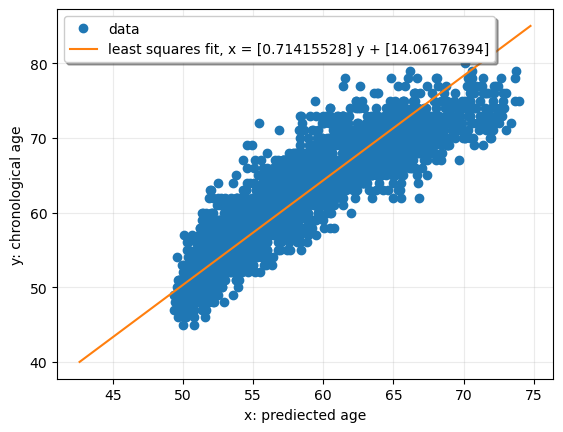

In [62]:
plot_bias_correction_result(MDD_pred_df["age_pred"].to_numpy(), MDD_pred_df["f.21003.2.0"].to_numpy(), slope, intercept)

### Compute BAG

Brain Age Gap

In [70]:
MDD_pred_df["BAG"] = MDD_pred_df["age_unbiased"] - MDD_pred_df["f.21003.2.0"]

In [76]:
print(f"Max BAG: {MDD_pred_df['BAG'].max()}, Min BAG: {MDD_pred_df['BAG'].min()}")

Max BAG: 11.860275041713138, Min BAG: -14.07776281138976


In [8]:
threshold = 3  # brain age gap threshold
MDD_pred_df[MDD_pred_df["BAG"] > threshold]

,f.21003.2.0,f.20126.0.0,age_pred,age_unbiased,BAG
f.eid,,,,,
3303915,72,5,67.656752,75.046687,3.046687
3324153,57,4,56.921937,60.015202,3.015202
3830488,54,5,56.137458,58.916730,4.916730
5917876,74,4,69.673020,77.869978,3.869978
4707661,63,3,61.348597,66.213657,3.213657
...,...,...,...,...,...
4208971,70,3,70.110594,78.482693,8.482693
3074308,71,3,66.976559,74.094244,3.094244
3677631,57,4,57.701833,61.107256,4.107256


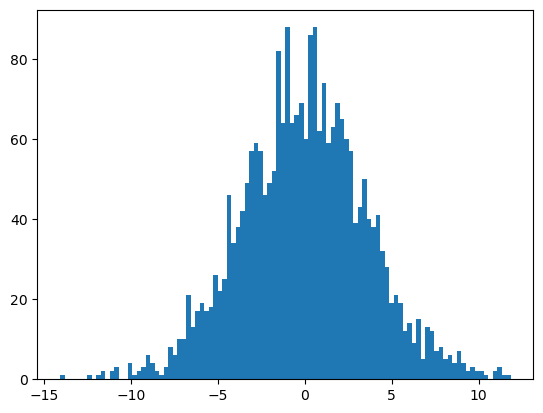

In [13]:
plt.hist(MDD_pred_df["BAG"], 100)
#plt.hist(MDD_pred_df[MDD_pred_df["f.20126.0.0"]==3.0]["BAG"], 100)
plt.show()

In [14]:
MDD_pred_df["BAG"].describe()
#MDD_pred_df[MDD_pred_df["f.20126.0.0"]==3.0]["BAG"].describe()

count    2461.000000
mean       -0.027872
std         3.621428
min       -14.077763
25%        -2.469553
50%        -0.001248
75%         2.312370
max        11.860275
Name: BAG, dtype: float64

In [12]:
print(mean_absolute_error(MDD_pred_df["f.21003.2.0"], MDD_pred_df["age_unbiased"]))
print(mean_squared_error(MDD_pred_df["f.21003.2.0"], MDD_pred_df["age_unbiased"]))

2.8510306877407556
13.110191940983505


### Save Results

In [69]:
MDD_pred_df.to_csv(f"./data_info/T1_MNI_20252_2_0/MDD_pred_age_{MDD_num}.csv")

In [14]:
MDD_pred_df = pd.read_csv("./data_info/T1_MNI_20252_2_0/MDD_pred_age_2461.csv")
MDD_pred_df.set_index("f.eid", inplace=True)
MDD_pred_df

,f.21003.2.0,f.20126.0.0,age_pred,age_unbiased,BAG
f.eid,,,,,
3303915,72,5,67.656752,75.046687,3.046687
3111573,69,4,60.408829,64.897742,-4.102258
2688028,60,4,56.256334,59.083187,-0.916813
2330198,63,5,59.066514,63.018159,0.018159
1244402,77,4,70.601883,79.170625,2.170625
...,...,...,...,...,...
5743070,77,3,68.748035,76.574762,-0.425238
4966663,70,3,63.001642,68.528344,-1.471656
4947696,60,4,54.515540,56.645631,-3.354369


# Merge All the results

In [46]:
data_info_df = pd.read_csv("./data_info/T1_MNI_20252_2_0/T1_MNI_20252_2_0.csv")
data_info_df.set_index("f.eid", inplace=True)

In [26]:
print(HC_pred_df.head())
print(MDD_pred_df.head())
print(data_info_df.head())

         f.21003.2.0   age_pred  age_unbiased     error
f.eid                                                  
1198929         70.0  58.789781     62.630661 -7.369339
3030287         60.0  56.418017     59.309585 -0.690415
3055051         71.0  63.230960     68.849447 -2.150553
2828573         59.0  55.169477     57.561309 -1.438691
2507464         70.0  65.875464     72.552430  2.552430
         f.21003.2.0  f.20126.0.0   age_pred  age_unbiased       BAG
f.eid                                                               
3303915           72            5  67.656752     75.046687  3.046687
3111573           69            4  60.408829     64.897742 -4.102258
2688028           60            4  56.256334     59.083187 -0.916813
2330198           63            5  59.066514     63.018159  0.018159
1244402           77            4  70.601883     79.170625  2.170625
     f.eid  f.21003.2.0  f.20126.0.0  f.2976.2.0 status path   MNI
0  5024977         65.0          NaN         NaN    NaN  N

In [59]:
ID = 5932644
print(data_info_df.loc[ID])
print()
#print(HC_pred_df.loc[ID])
print()
#printMDD_pred_df.loc[ID])
print()
print(data_info.loc[ID])
print()

f.21003.2.0     68.0
f.20126.0.0      NaN
f.2976.2.0      50.0
status           NaN
path             NaN
MNI             True
age_pred        None
age_unbiased    None
error           None
BAG             None
Name: 5932644, dtype: object



BAG              NaN
MNI             True
age_pred         NaN
age_unbiased     NaN
error            NaN
f.20126.0.0      NaN
f.21003.2.0     68.0
f.2976.2.0      50.0
path             NaN
status           NaN
Name: 5932644, dtype: object



## Combine HC and MDD

In [47]:
data_info_df["age_pred"]=None
data_info_df["age_unbiased"]=None
data_info_df["error"]=None
data_info_df["BAG"]=None

In [48]:
# Merge HC and MDD info
data_info = data_info_df.combine_first(HC_pred_df)
data_info = data_info.combine_first(MDD_pred_df)

## Map str "status" to int "label"

In [30]:
status_map={
    "HC" : int(0),
    "mdd" : int(1),
}

data_info["label"] = data_info["status"].map(status_map)
data_info

,f.21003.2.0,f.20126.0.0,f.2976.2.0,status,path,MNI,age_pred,age_unbiased,error,BAG,label
f.eid,,,,,,,,,,,
1000145,61.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
1000393,56.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
1000732,70.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
1000968,52.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
1000997,65.0,0.0,NaN,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,59.393248,63.475669,-1.524331,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6026152,63.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
6026166,66.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
6026219,67.0,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN


In [31]:
# switch columns
cols = ["f.21003.2.0", "f.20126.0.0", "f.2976.2.0", "label", "status", "path", "MNI", "age_pred", "age_unbiased", "error", "BAG"]
data_info = data_info[cols]
data_info

,f.21003.2.0,f.20126.0.0,f.2976.2.0,label,status,path,MNI,age_pred,age_unbiased,error,BAG
f.eid,,,,,,,,,,,
1000145,61.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000393,56.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000732,70.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000968,52.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000997,65.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,59.393248,63.475669,-1.524331,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6026152,63.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
6026166,66.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
6026219,67.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


## Save Results

In [32]:
data_info.to_csv(f"./data_info/T1_MNI_20252_2_0/data_info.csv")

In [33]:
data_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/data_info.csv")
data_info.set_index("f.eid", inplace=True)
data_info

,f.21003.2.0,f.20126.0.0,f.2976.2.0,label,status,path,MNI,age_pred,age_unbiased,error,BAG
f.eid,,,,,,,,,,,
1000145,61.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000393,56.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000732,70.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000968,52.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1000997,65.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,59.393248,63.475669,-1.524331,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6026152,63.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
6026166,66.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
6026219,67.0,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


In [34]:
HC_info = data_info[(data_info["status"]=="HC") & (data_info["MNI"]==True)]
HC_info.to_csv(f"./data_info/T1_MNI_20252_2_0/HC_info.csv")

In [13]:
HC_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/HC_info.csv")
HC_info.set_index("f.eid", inplace=True)
HC_info

,f.21003.2.0,f.20126.0.0,f.2976.2.0,label,status,path,MNI,age_pred,age_unbiased,error,BAG
f.eid,,,,,,,,,,,
1000997,65.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,59.393248,63.475669,-1.524331,NaN
1001102,73.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,65.224751,71.641265,-1.358735,NaN
1001962,57.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,53.772959,55.605827,-1.394173,NaN
1002244,68.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,59.448833,63.553502,-4.446498,NaN
1002708,76.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,71.929408,81.029499,5.029499,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6021303,78.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,66.726163,73.743626,-4.256374,NaN
6021795,71.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,60.309863,64.759164,-6.240836,NaN
6022310,63.0,0.0,NaN,0.0,HC,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/H...,True,57.193035,60.394808,-2.605192,NaN


In [36]:
MDD_info = data_info[(data_info["status"]=="mdd") & (data_info["MNI"]==True)]
MDD_info.to_csv(f"./data_info/T1_MNI_20252_2_0/MDD_info.csv")

In [14]:
MDD_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/MDD_info.csv")
MDD_info.set_index("f.eid", inplace=True)
MDD_info

,f.21003.2.0,f.20126.0.0,f.2976.2.0,label,status,path,MNI,age_pred,age_unbiased,error,BAG
f.eid,,,,,,,,,,,
1002490,69.0,4.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,64.996819,71.322101,NaN,2.322101
1004202,67.0,5.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,62.713792,68.125279,NaN,1.125279
1005164,52.0,4.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,52.152863,53.337279,NaN,1.337279
1005224,60.0,3.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,56.107731,58.875106,NaN,-1.124894
1006009,72.0,5.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,64.951324,71.258396,NaN,-0.741604
...,...,...,...,...,...,...,...,...,...,...,...
6017100,48.0,4.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,50.148889,50.531203,NaN,2.531203
6017768,68.0,4.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,64.038885,69.980749,NaN,1.980749
6017948,61.0,5.0,NaN,1.0,mdd,/disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...,True,55.987075,58.706157,NaN,-2.293843


In [81]:
# MDD_pred_df.sort_index()

# BAG by re-trained SFCN

## Dataloader

In [21]:
HC_path_list_2 = HC_info["path"].tolist()
MDD_path_list_2 = MDD_info["path"].tolist()

batch_size = 50
HC_loader_2 = DataLoader(HC_path_list_2, batch_size=batch_size, pin_memory=True)  ## NO shuffle
MDD_loader_2 = DataLoader(MDD_path_list_2, batch_size=batch_size, pin_memory=True)  ## NO shuffle

## predict

In [22]:
HC_age_pred_list_2 = inference_brain_age(HC_loader_2, bin_center)

print(len(HC_age_pred_list_2))

100%|█████████████████████████████████████████████████████████████████████████████████| 137/137 [15:04<00:00,  6.61s/it]

6802


In [27]:
MDD_age_pred_list_2 = inference_brain_age(MDD_loader_2, bin_center)

print(len(MDD_age_pred_list_2))

2461


In [28]:
HC_info["age_pred_2"] = HC_age_pred_list_2
MDD_info["age_pred_2"] = MDD_age_pred_list_2

## BAG

In [31]:
HC_age_unbiased_2, intercept_2, slope_2 = bias_correction(HC_info["f.21003.2.0"].to_numpy().reshape(-1, 1), HC_info["age_pred_2"].to_numpy().reshape(-1, 1))
HC_info["age_unbiased_2"] = HC_age_unbiased_2
MDD_age_unbiased_2 = (MDD_info["age_pred_2"].to_numpy() - intercept_2) / (slope_2 + np.finfo(np.float32).eps) # avoid division by 0
MDD_info["age_unbiased_2"] = MDD_age_unbiased_2

In [33]:
print(f"{intercept_2} \t {slope_2}")

[5.76051599] 	 [0.90442238]


In [35]:
HC_info["error_2"] = HC_info["age_unbiased_2"] - HC_info["f.21003.2.0"]
MDD_info["BAG_2"] = MDD_info["age_unbiased_2"] - MDD_info["f.21003.2.0"]

In [37]:
HC_info.to_csv(f"./data_info/T1_MNI_20252_2_0/HC_info_2.csv")
MDD_info.to_csv(f"./data_info/T1_MNI_20252_2_0/MDD_info_2.csv")

## Analysis

In [3]:
MDD_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/MDD_info_2.csv")
MDD_info.set_index("f.eid", inplace=True)
HC_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/HC_info_2.csv")
HC_info.set_index("f.eid", inplace=True)

In [5]:
print(mean_absolute_error(MDD_info["f.21003.2.0"], MDD_info["age_unbiased_2"]))
print(mean_absolute_error(MDD_info["f.21003.2.0"], MDD_info["age_pred_2"]))

print(mean_squared_error(MDD_info["f.21003.2.0"], MDD_info["age_unbiased_2"]))
print(mean_squared_error(MDD_info["f.21003.2.0"], MDD_info["age_pred_2"]))

2.2483879483241673
2.171814508866192
8.09808770073131
7.510114415296181


In [6]:
print(mean_absolute_error(HC_info["f.21003.2.0"], HC_info["age_unbiased_2"]))
print(mean_absolute_error(HC_info["f.21003.2.0"], HC_info["age_pred_2"]))

print(mean_squared_error(HC_info["f.21003.2.0"], HC_info["age_unbiased_2"]))
print(mean_squared_error(HC_info["f.21003.2.0"], HC_info["age_pred_2"]))

1.716476503225889
1.6771862921343563
4.884212853937769
4.615999330176745


In [57]:
print(MDD_info["BAG_2"].describe())
(MDD_info["age_pred_2"]-MDD_info["f.21003.2.0"]).describe()

count    2461.000000
mean        0.066913
std         2.845505
min       -10.652335
25%        -1.754830
50%         0.065853
75%         1.997351
max         9.997146
Name: BAG_2, dtype: float64


count    2461.000000
mean       -0.110287
std         2.738795
min        -9.990656
25%        -1.915859
50%        -0.078544
75%         1.750618
max         9.736553
dtype: float64

count    6802.000000
mean       -0.318218
std         2.124947
min       -18.312564
25%        -1.678398
50%        -0.313296
75%         1.064346
max        14.850798
dtype: float64

In [56]:
print(HC_info["error_2"].describe())
(HC_info["age_pred_2"]-HC_info["f.21003.2.0"]).describe()

count    6802.000000
mean       -0.000008
std         2.210188
min       -19.219618
25%        -1.428977
50%        -0.014971
75%         1.421916
max        15.546177
Name: error_2, dtype: float64


count    6802.000000
mean       -0.318218
std         2.124947
min       -18.312564
25%        -1.678398
50%        -0.313296
75%         1.064346
max        14.850798
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

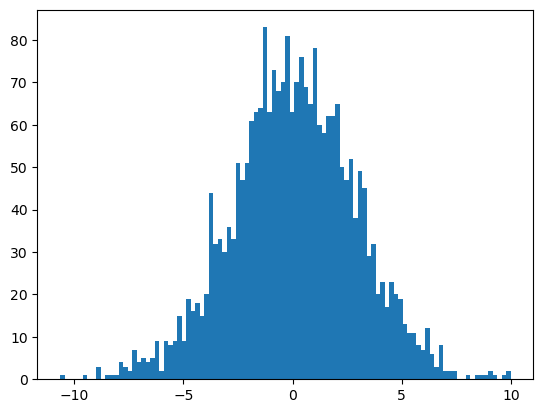

In [59]:
plt.hist(MDD_info["BAG_2"], 100)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

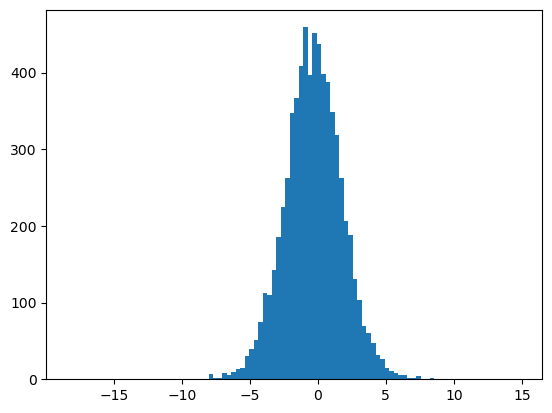

In [63]:
plt.hist(HC_info["age_pred_2"]-HC_info["f.21003.2.0"], 100)
plt.show

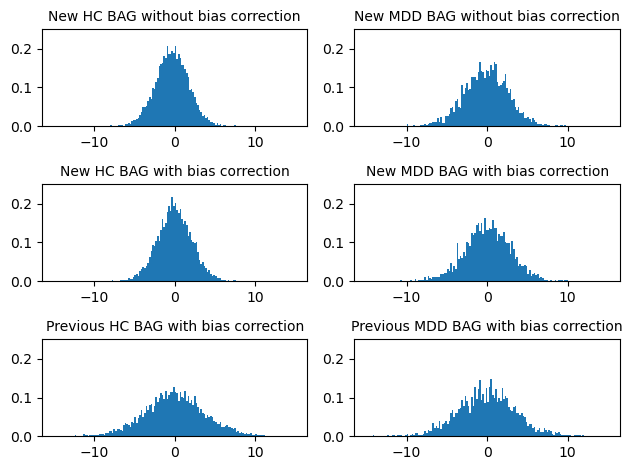

In [88]:
fig, ((ax0, ax3), (ax1, ax4), (ax2, ax5)) = plt.subplots(nrows=3, ncols=2)

size = 10
range = (-15, 15)
bins=150
normed=True
y_range=[0.0, 0.25]

major_ticks = np.arange(0, 0.25, 25)
minor_ticks = np.arange(0, 0.25, 5)

ax0.hist(HC_info["age_pred_2"]-HC_info["f.21003.2.0"], range=range, bins=bins, density=normed)
ax0.set_title('New HC BAG without bias correction', fontsize = size)
ax0.set_ylim(y_range)

ax1.hist(HC_info["error_2"], range=range, bins=bins, density=normed)
ax1.set_title('New HC BAG with bias correction', fontsize = size)
ax1.set_ylim(y_range)

ax2.hist(HC_info["error"], range=range, bins=bins, density=normed)
ax2.set_title('Previous HC BAG with bias correction', fontsize = size)
ax2.set_ylim(y_range)

ax3.hist(MDD_info["age_pred_2"]-MDD_info["f.21003.2.0"], range=range, bins=bins, density=normed)
ax3.set_title('New MDD BAG without bias correction', fontsize = size)
ax3.set_ylim(y_range)

ax4.hist(MDD_info["BAG_2"], range=range, bins=bins, density=normed)
ax4.set_title('New MDD BAG with bias correction', fontsize = size)
ax4.set_ylim(y_range)

ax5.hist(MDD_info["BAG"], range=range, bins=bins, density=normed)
ax5.set_title('Previous MDD BAG with bias correction', fontsize = size)
ax5.set_ylim(y_range)

fig.tight_layout()
plt.show()

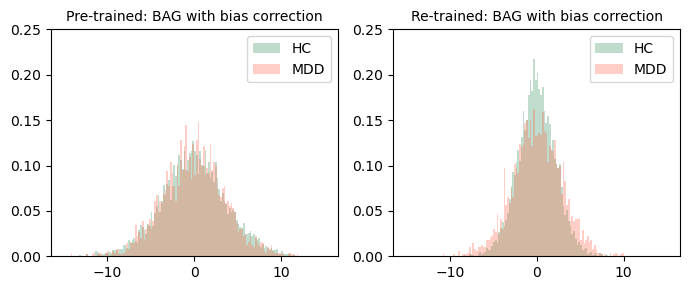

In [16]:
# fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1)
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

size = 10
range = (-15, 15)
bins=150
transparency=0.3
normed=True
y_range=[0.0, 0.25]

# ax0.hist(HC_info["age_pred_2"]-HC_info["f.21003.2.0"], range=range, bins=bins, alpha=transparency, density=normed, color="seagreen")
# ax0.hist(MDD_info["age_pred_2"]-MDD_info["f.21003.2.0"], range=range, bins=bins, alpha=transparency, density=normed, color="tomato")
# ax0.legend(['HC', 'MDD'])
# ax0.set_title('New BAG without bias correction', fontsize = size)
# ax0.set_ylim(y_range)

ax1.hist(HC_info["error_2"], range=range, bins=bins, alpha=transparency, density=normed, color="seagreen")
ax1.hist(MDD_info["BAG_2"], range=range, bins=bins, alpha=transparency, density=normed, color="tomato")
ax1.legend(['HC', 'MDD'])
#ax1.set_title('New BAG with bias correction', fontsize = size)
ax1.set_title('Re-trained: BAG with bias correction', fontsize = size)
ax1.set_ylim(y_range)

ax2.hist(HC_info["error"], range=range, bins=bins, alpha=transparency, density=normed, color="seagreen")
ax2.hist(MDD_info["BAG"], range=range, bins=bins, alpha=transparency, density=normed, color="tomato")
ax2.legend(['HC', 'MDD'])
# ax2.set_title('Previous BAG with bias correction', fontsize = size)
ax2.set_title('Pre-trained: BAG with bias correction', fontsize = size)
ax2.set_ylim(y_range)

fig.tight_layout()
plt.show()

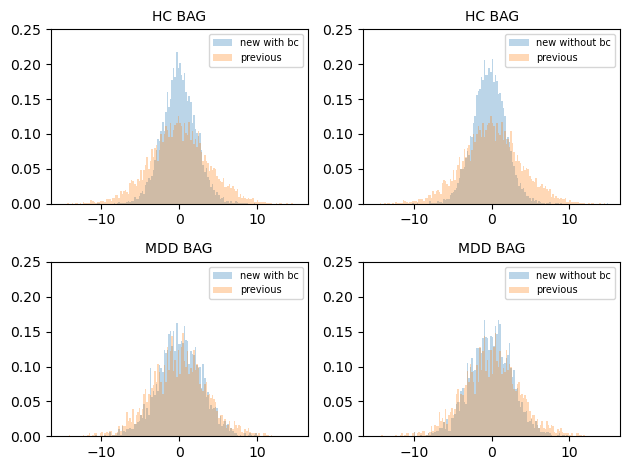

In [100]:
fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(nrows=2, ncols=2)

size = 10
range = (-15, 15)
bins=150
transparency=0.3
normed=True
y_range=[0.0, 0.25]

ax0.hist(HC_info["error_2"], range=range, bins=bins, alpha=transparency, density=normed)
ax0.hist(HC_info["error"], range=range, bins=bins, alpha=transparency, density=normed)
ax0.legend(['new with bc', 'previous'], fontsize = size*0.7)
ax0.set_title('HC BAG', fontsize = size)
ax0.set_ylim(y_range)

ax2.hist(HC_info["age_pred_2"]-HC_info["f.21003.2.0"], range=range, bins=bins, alpha=transparency, density=normed)
ax2.hist(HC_info["error"], range=range, bins=bins, alpha=transparency, density=normed)
ax2.legend(['new without bc', 'previous'], fontsize = size*0.7)
ax2.set_title('HC BAG', fontsize = size)
ax2.set_ylim(y_range)

ax1.hist(MDD_info["BAG_2"], range=range, bins=bins, alpha=transparency, density=normed)
ax1.hist(MDD_info["BAG"], range=range, bins=bins, alpha=transparency, density=normed)
ax1.legend(['new with bc', 'previous'], fontsize = size*0.7)
ax1.set_title('MDD BAG', fontsize = size)
ax1.set_ylim(y_range)

ax3.hist(MDD_info["age_pred_2"]-MDD_info["f.21003.2.0"], range=range, bins=bins, alpha=transparency, density=normed)
ax3.hist(MDD_info["BAG"], range=range, bins=bins, alpha=transparency, density=normed)
ax3.legend(['new without bc', 'previous'], fontsize = size*0.7)
ax3.set_title('MDD BAG', fontsize = size)
ax3.set_ylim(y_range)

fig.tight_layout()
plt.show()

# Pick data for cVAE

## Set BAG threshold for MDD

MDD dataset size: 568


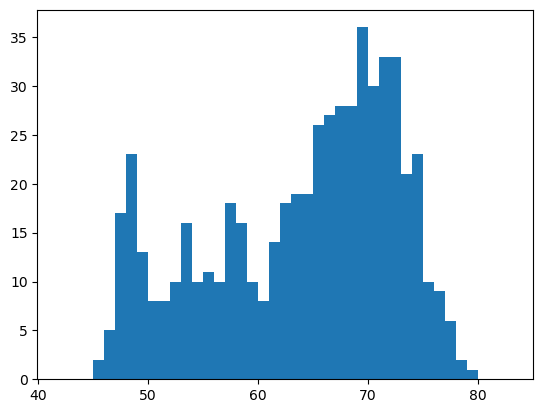

[ 0.  0.  0.  2.  5. 17. 23. 13.  8.  8. 10. 16. 10. 11. 10. 18. 16. 10.
  8. 14. 18. 19. 19. 26. 27. 28. 28. 36. 30. 33. 33. 21. 23. 10.  9.  6.
  2.  1.  0.  0.  0.]


{'42.0~43.0': 0.0,
 '43.0~44.0': 0.0,
 '44.0~45.0': 0.0,
 '45.0~46.0': 2.0,
 '46.0~47.0': 5.0,
 '47.0~48.0': 17.0,
 '48.0~49.0': 23.0,
 '49.0~50.0': 13.0,
 '50.0~51.0': 8.0,
 '51.0~52.0': 8.0,
 '52.0~53.0': 10.0,
 '53.0~54.0': 16.0,
 '54.0~55.0': 10.0,
 '55.0~56.0': 11.0,
 '56.0~57.0': 10.0,
 '57.0~58.0': 18.0,
 '58.0~59.0': 16.0,
 '59.0~60.0': 10.0,
 '60.0~61.0': 8.0,
 '61.0~62.0': 14.0,
 '62.0~63.0': 18.0,
 '63.0~64.0': 19.0,
 '64.0~65.0': 19.0,
 '65.0~66.0': 26.0,
 '66.0~67.0': 27.0,
 '67.0~68.0': 28.0,
 '68.0~69.0': 28.0,
 '69.0~70.0': 36.0,
 '70.0~71.0': 30.0,
 '71.0~72.0': 33.0,
 '72.0~73.0': 33.0,
 '73.0~74.0': 21.0,
 '74.0~75.0': 23.0,
 '75.0~76.0': 10.0,
 '76.0~77.0': 9.0,
 '77.0~78.0': 6.0,
 '78.0~79.0': 2.0,
 '79.0~80.0': 1.0,
 '80.0~81.0': 0.0,
 '81.0~82.0': 0.0,
 '82.0~83.0': 0.0}

In [38]:
# select MDD scans with large BAG
BAG_threshold = 2.5
MDD_dataset_0 = MDD_info[MDD_info["BAG"] > BAG_threshold] # MDD_dataset_0 maybe changed later when selected HC
print(f"MDD dataset size: {len(MDD_dataset_0)}")

# see the distribution of chronological age
bins = np.arange(42, 84)
hist = plt.hist(MDD_dataset_0["f.21003.2.0"], bins)
plt.show()

counts = hist[0]
bin_edges = hist[1]
# print(f"histogram counts: {len(hist[0])}")
# print(f"histogram bin edgs: {len(hist[1])}")

print(counts)
# form a dist of age distribution, [age_1, age_2) -- left included right excluded
age_map = {f"{bin_edges[i]}~{bin_edges[i+1]}": counts[i] for i in range(len(counts))}
age_map

## Pick HC accordingly

In [39]:
lack_HC = {} # number of lacked HC compared with the original mdd age_map -- {range: count}
age_selected_map = {} # the subjects selected at last -- {range: {count: ..., HC: [ids], mdd:[ids]}}

for range, len_MDD in age_map.items():
    # range: age range -- [a, b)
    # len_MDD: number of mdd within age range
    
    if len_MDD == 0:
        continue
    #print(range)
    age_selected_map[range] = {}

    # age range edges
    left = float(range.split("~")[0])
    right = float(range.split("~")[1])
    
    # find HC within the age range
    subset_HC = HC_info[(HC_info["f.21003.2.0"]>=left) & (HC_info["f.21003.2.0"]<right)]
    # number of HC available within a certain age range
    len_HC = len(subset_HC)
    # gona pick HC with less |error|
    subset_HC = subset_HC.sort_values(by='error', key=abs)
    
    # find MDD within the age range
    subset_MDD = MDD_dataset_0[(MDD_dataset_0["f.21003.2.0"]>=left) & (MDD_dataset_0["f.21003.2.0"]<right)]
    if len_MDD != len(subset_MDD):
        print("{range}: length of MDD went wrong!")
    # gona pick MDD with more BAG
    subset_MDD = subset_MDD.sort_values(by='BAG', ascending=False)

    #print(subset_HC)
    #print()
    #print(subset_MDD)

    # pick the same number of HC and MDD, delete the extra ones
    # !! can change to another strategy later
    n_samples = int(min(len_HC, len_MDD))
    if len_HC < len_MDD: # not enough data, handle later, !! e.g. add HC of other age range 
        lack_HC[range] = len_MDD - len_HC
    age_selected_map[range]["count"] = n_samples
    age_selected_map[range]["HC"] = subset_HC.index.tolist()[:n_samples]
    age_selected_map[range]["MDD"] = subset_MDD.index.tolist()[:n_samples]

In [40]:
# check #HC not matched with MDD
lack_HC

{'45.0~46.0': 1.0}

In [41]:
# total number of data for training and validation, leave test set for now
n_total = sum(age_selected_map[k]["count"] for k in age_selected_map.keys())
print(f"Choose {n_total} HC and {n_total} MDD samples for cVAE")
print()

# see info of first several age ranges
for range, info in list(age_selected_map.items())[:5]:
    print("------------------------------------------")  
    print(f"range: {range}: ")
    print(f"   count: {info['count']}")
    print(f"   HC_id: {info['HC']}")
    print(f"   HC_id: {info['HC']}")
    

Choose 567 HC and 567 MDD samples for cVAE

------------------------------------------
range: 45.0~46.0: 
   count: 1
   HC_id: [1875899]
   HC_id: [1875899]
------------------------------------------
range: 46.0~47.0: 
   count: 5
   HC_id: [4005522, 4514507, 5165669, 2769223, 4810390]
   HC_id: [4005522, 4514507, 5165669, 2769223, 4810390]
------------------------------------------
range: 47.0~48.0: 
   count: 17
   HC_id: [5951148, 1014411, 3120623, 3886953, 1692877, 2118866, 4211083, 1232070, 1061108, 2216124, 4500990, 1071459, 4452396, 4760059, 4359584, 5144887, 5992523]
   HC_id: [5951148, 1014411, 3120623, 3886953, 1692877, 2118866, 4211083, 1232070, 1061108, 2216124, 4500990, 1071459, 4452396, 4760059, 4359584, 5144887, 5992523]
------------------------------------------
range: 48.0~49.0: 
   count: 23
   HC_id: [2245419, 3184396, 3650926, 3894741, 3389872, 3358042, 5545603, 1390536, 4336630, 1878504, 4600393, 5348128, 4181397, 3476801, 3920668, 2208556, 1752009, 1996330, 55798

## Get the needed subject info

In [42]:
# Get subject ID
HC_id = []
MDD_id = []

for range, info in age_selected_map.items():
    HC_id.extend(info["HC"])
    MDD_id.extend(info["MDD"])

print(len(HC_id))
print(len(MDD_id))

567
567


In [43]:
# Create dataset (paths) for cVAE
HC_dataset = HC_info.loc[HC_id]
MDD_dataset = MDD_info.loc[MDD_id]

## Save Results

In [44]:
HC_dataset.to_csv(f"./data_info/T1_MNI_20252_2_0/HC_dataset_{len(HC_dataset)}.csv")
MDD_dataset.to_csv(f"./data_info/T1_MNI_20252_2_0/MDD_dataset_{len(MDD_dataset)}.csv")

# Check results with Yaowen

## load syw's results

In [22]:
syw = pd.read_csv("./temp/brain_age_info_clean.csv")
syw["f.eid"] = syw["filename"].str.split('_').str[0].astype(int)
syw.set_index("f.eid", inplace=True)
print(syw.dtypes)
syw.head()

study                  object
filename               object
age                     int64
brain_age             float64
MDD_status            float64
brain_age_unbiased    float64
dtype: object


,study,filename,age,brain_age,MDD_status,brain_age_unbiased
f.eid,,,,,,
1620797,ukb,1620797_20252_2_0.zip,57,56.018711,1.0,55.982476
1303386,ukb,1303386_20252_2_0.zip,68,60.510855,0.0,63.995101
1242643,ukb,1242643_20252_2_0.zip,70,67.265441,1.0,76.043239
1577440,ukb,1577440_20252_2_0.zip,66,61.164543,1.0,65.161082
4192093,ukb,4192093_20252_2_0.zip,56,52.739286,0.0,50.132973


In [23]:
syw_HC = syw[syw["MDD_status"]==0.0]
print(len(syw_HC))

syw_MDD = syw[syw["MDD_status"]==1.0]
print(len(syw_MDD))

6797
2457


In [51]:
print(set(HC_info.index) - set(syw_HC.index)) # I have 5 more HC than yaowen
print(set(syw_HC.index) - set(HC_info.index))
print(set(MDD_info.index) - set(syw_MDD.index)) # I have 4 more MDD than yaowen
print(set(syw_MDD.index) - set(MDD_info.index))

{1625102, 3009935, 3112086, 3757334, 3117020}
set()
{2827090, 5472996, 3563276, 3073231}
set()


In [155]:
syw_MDD

,study,filename,age,brain_age,MDD_status,brain_age_unbiased
f.eid,,,,,,
1620797,ukb,1620797_20252_2_0.zip,57,56.018711,1.0,55.982476
1242643,ukb,1242643_20252_2_0.zip,70,67.265441,1.0,76.043239
1577440,ukb,1577440_20252_2_0.zip,66,61.164543,1.0,65.161082
3211618,ukb,3211618_20252_2_0.zip,64,61.109197,1.0,65.062361
3215237,ukb,3215237_20252_2_0.zip,68,64.335487,1.0,70.817088
...,...,...,...,...,...,...
2285157,ukb,2285157_20252_2_0.zip,54,54.254961,1.0,52.836479
5920238,ukb,5920238_20252_2_0.zip,64,58.410126,1.0,60.248036
2930024,ukb,2930024_20252_2_0.zip,66,58.984439,1.0,61.272436


## Using samples to compare

In [25]:
ID = 4511501 # 
print(MDD_info.loc[ID])
print()
print(syw_MDD.loc[ID])
print()

paths = [MDD_info.loc[ID]["path"]]

samples_arr = create_dataset_from_nii_path_list(paths)

samples = torch.from_numpy(samples_arr)
n_sample = samples.shape[0]
samples = samples.type(torch.FloatTensor).cuda() ## double to float to cuda

model.eval()
with torch.no_grad():
    # a list of only one element: a tensor of size [samples.shape[0], 40, 1, 1, 1], in GPU
    output_list = model(samples)

# to CPU and reshape to [samples.shape[0], 40]
output_tensor =  output_list[0].cpu().reshape([n_sample, -1])
output_arr = output_tensor.numpy()

# exp: map from log domin to prob
prob_dist = np.exp(output_arr) 
prediction = prob_dist @ bin_center

print(samples_arr.shape)
print(prediction)

f.21003.2.0                                                  76.0
f.20126.0.0                                                   3.0
f.2976.2.0                                                    NaN
status                                                        mdd
path            /disk/scratch/s2442138/data/T1_MNI_20252_2_0/m...
MNI                                                          True
age_pred                                                71.406265
age_unbiased                                            80.296964
error                                                         NaN
BAG                                                      4.296964
Name: 4511501, dtype: object

study                                   ukb
filename              4511501_20252_2_0.zip
age                                      76
brain_age                           69.0788
MDD_status                              1.0
brain_age_unbiased                79.277722
Name: 4511501, dtype: object

(1, 1, 160, 192,

In [168]:
with open(f'./temp/{ID}.npy', 'wb') as f:
    np.save(f, samples_arr)

ID = 3303915 

我的数据 + 我的fubini模型 --> 67...
我的数据 + yw的mac模型 --> 67...
yw的数据 + yw的mac模型 --> 67...
yw的数据 + yw的fubini模型 --> 65...
yw的数据 + 我的fubini模型 --> 67...

我存在fubini上的数据预处理之后 == 我本地数据预处理之后 --> .nii数据的提取应该没有问题




In [3]:
ID = 3303915
with open(f'temp/{ID}.npy', 'rb') as f:
    arr_prep_1 = np.load(f)

In [9]:
ID = 1620797
path = f"temp/{ID}_MNI.nii.gz"
# extract nii object
img = nib.load(path)
# extract raw arr data
arr_raw_0 = img.get_fdata()
# preprocess
arr_temp = arr_raw_0/arr_raw_0.mean()
arr_prep_0 = dpu.crop_center(arr_temp, (160, 192, 160)) # crop

In [18]:
(arr_prep_1 == arr_prep_0).all()

True

In [10]:
arr_prep = arr_prep_0.reshape((1,1,160,192,160))

In [11]:
samples = torch.from_numpy(arr_prep)
n_sample = samples.shape[0]
samples = samples.type(torch.FloatTensor).cuda() ## double to float to cuda

model.eval()
with torch.no_grad():
    # a list of only one element: a tensor of size [samples.shape[0], 40, 1, 1, 1], in GPU
    output_list = model(samples)

# to CPU and reshape to [samples.shape[0], 40]
output_tensor =  output_list[0].cpu().reshape([n_sample, -1])
output_arr = output_tensor.numpy()

# exp: map from log domin to prob
prob_dist = np.exp(output_arr) 
prediction = prob_dist @ bin_center

print(prediction)

[54.75584073]


In [20]:
with open(f'temp/yaowen_unprocessed.npy', 'rb') as f:
    syw_unp = np.load(f)
with open(f'temp/yaowen_preprocessed.npy', 'rb') as f:
    syw_prep = np.load(f)

In [23]:
print(syw_unp.shape)
print(arr_raw_0.shape)
print((syw_unp == arr_raw_0).all())

(182, 218, 182)
(182, 218, 182)
True


In [46]:
print(syw_prep.dtype)
print(syw_prep.shape)

print(arr_prep_1.dtype)
print(arr_prep_1.shape)

print((syw_prep==arr_prep).all())

float32
(1, 1, 160, 192, 160)
float64
(1, 1, 160, 192, 160)
False


In [37]:
print(syw_prep[:,:,86,:,:].sum())
print(arr_prep_1[:,:,86,:,:].sum())

70342.625
70342.6074978778


In [40]:
arr_raw_f = arr_raw_0.astype(np.float32)
arr_temp_f = arr_raw_f / arr_raw_f.mean()
arr_prep_f = dpu.crop_center(arr_temp_f, (160, 192, 160))

In [41]:
print((syw_prep==arr_prep_f).all()) # dif of prep data is only a matter of converting raw to float32

True


In [47]:
samples = torch.from_numpy(syw_prep)
n_sample = samples.shape[0]
samples = samples.type(torch.FloatTensor).cuda() ## double to float to cuda

model.eval()
with torch.no_grad():
    # a list of only one element: a tensor of size [samples.shape[0], 40, 1, 1, 1], in GPU
    output_list = model(samples)

# to CPU and reshape to [samples.shape[0], 40]
output_tensor =  output_list[0].cpu().reshape([n_sample, -1])
output_arr = output_tensor.numpy()

# exp: map from log domin to prob
prob_dist = np.exp(output_arr) 
prediction = prob_dist @ bin_center

print(samples_arr.shape)
print(prediction)

(1, 1, 160, 192, 160)
[67.65648969]


## see dif of predicted age

In [60]:
HC_info[["age_pred", "f.21003.2.0"]].merge(syw_HC[["brain_age", "age"]], on="f.eid", how="left")

,age_pred,f.21003.2.0,brain_age,age
f.eid,,,,
1000997,59.393248,65.0,58.761399,65.0
1001102,65.224751,73.0,63.925681,73.0
1001962,53.772959,57.0,53.464337,57.0
1002244,59.448833,68.0,60.822426,68.0
1002708,71.929408,76.0,69.586775,76.0
...,...,...,...,...
6021303,66.726163,78.0,67.228228,78.0
6021795,60.309863,71.0,59.383496,71.0
6022310,57.193035,63.0,58.153450,63.0


In [61]:
MDD_info[["age_pred", "f.21003.2.0"]].merge(syw_MDD[["brain_age", "age"]], on="f.eid", how="left")

,age_pred,f.21003.2.0,brain_age,age
f.eid,,,,
1002490,64.996819,69.0,66.573383,69.0
1004202,62.713792,67.0,64.241738,67.0
1005164,52.152863,52.0,52.572897,52.0
1005224,56.107731,60.0,55.256537,60.0
1006009,64.951324,72.0,64.328288,72.0
...,...,...,...,...
6017100,50.148889,48.0,54.788737,48.0
6017768,64.038885,68.0,63.979994,68.0
6017948,55.987075,61.0,56.098235,61.0
